In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import random
import os
import time
from collections import defaultdict

In [23]:
df = pd.read_excel("Data/dist_data.xls")
df.loc[df['distw'] == '.', 'distw'] = np.nan
df.loc[df['distwces'] == '.', 'distwces'] = np.nan
df['distw'] = df['distw'].astype(float).fillna(df['distw'].mean())
df['distwces'] = df['distwces'].astype(float).fillna(df['distwces'].mean())
values = df.values
col_to_ind = dict(zip(df.columns, range(len(df.columns))))
id_to_iso = list(set(df['iso_o']))
n = len(id_to_iso)
iso_to_id = {}
for i, key in enumerate(id_to_iso):
    iso_to_id[key] = i
df.sum()

iso_o            ABWABWABWABWABWABWABWABWABWABWABWABWABWABWABWA...
iso_d            ABWAFGAGOAIAALBANDANTAREARGARMATGAUSAUTAZEBDIB...
contig                                                         616
comlang_off                                                   8750
comlang_ethno                                                 8488
colony                                                         482
comcol                                                        5886
curcol                                                          64
col45                                                          312
smctry                                                         401
dist                                               425582766.87904
distcap                                            425070853.17624
distw                                             421113537.101565
distwces                                          419985668.833861
dtype: object

In [24]:
# Parameters
k = 3
stimul = -1
cap_dist = False

# col_to_ind

In [25]:
dist = np.array([[0.0] * n for i in range(n)])
dists = []
dist_indices = [10, 11, 12, 13] #[col_to_ind[x] for x in ['dist', 'distcap', 'distw', 'distwces']]
for i in dist_indices:
    values.T[i] = values.T[i] / values.T[i].max()
dist_col = col_to_ind['dist']
for i in df.index:
    row = values[i]
    one = row[0]
    two = row[1]
    if one != two:
        # (1 − Contiguity[2]) + (1 − CommonColonizer[]) + GeodesicDistanceij + GeneticDistanceij +
        # LinguisticDistanceij + ReligiousDistanceij
        d = (1 - row[col_to_ind['contig']]) + (1 - row[col_to_ind['comcol']]) + \
        0.5 * row[col_to_ind['comlang_off']] + 0.5 * row[col_to_ind['comlang_ethno']]
        if cap_dist:
            d += row[10]
        dist[iso_to_id[one]][iso_to_id[two]] = d
        dists.append(d)
dists = np.array(dists)
dist = -dist
for i in range(n):
    dist[i][i] = 0

In [26]:
def is_close(a, b):
    return abs(a - b) < 1e-5

for i in range(n):
    for j in range(i):
        try:
            assert is_close(dist[i][j], dist[j][i])
        except AssertionError:
            print(i, j, dist[i][j], dist[j][i])
            dist[i][j] = dist[j][i] = (dist[i][j] + dist[j][i]) / 2
    assert dist[i][i] == 0
with open("input.txt", "w") as file:
    print(n, k, file=file)
    for i in range(n):
        print(*dist[i], file=file)

In [27]:
with open("output.txt", "w") as file:
    print('#', end='', file=file)
time.sleep(0.1)

simple = True

if simple:
    open_file = "simple"
else:
    open_file = "difficult"
os.startfile("executable\\" + open_file)

while True:
    time.sleep(0.1)
    with open("output.txt") as file:
        s = file.readline().strip()
        if s != "#":
            break

In [28]:
time.sleep(0.1)
with open("output.txt") as file:
    id_to_coalition = list(map(int, file.readline().split()))

Used colors:
(220, 190, 255)
(145, 30, 180)
(245, 130, 48)


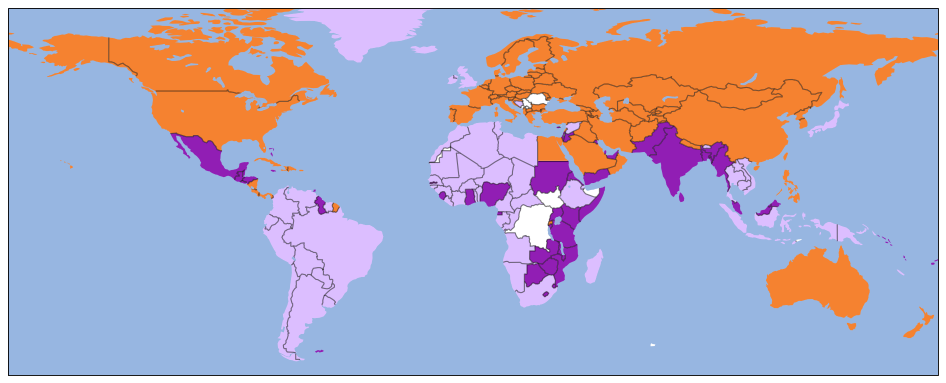

In [29]:
colors = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48),
          (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 212),
          (0, 128, 128), (220, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0),
          (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128)]
random.shuffle(colors)
good_colors = [(220, 190, 255),
               (145, 30, 180),
               (245, 130, 48),
               (128, 128, 0),
               (255, 250, 200)]
for c in good_colors:
    colors.remove(c)
colors = good_colors + colors
colors = [tuple(map(lambda x: x / 255, color)) for color in colors]
while len(colors) < k:
    colors.append((random.random(), random.random(), random.random()))
print("Used colors:")
for i in range(k):
    print(tuple(map(lambda x: round(x * 255), colors[i])))
plt.figure(figsize=(15, 10), dpi=80)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-150, 60, -25, 60])

shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
for country in countries:
    iso_name = country.attributes['ADM0_A3']
    if iso_name in iso_to_id:
        color = colors[id_to_coalition[iso_to_id[iso_name]]]
    else:
        color = (1, 1, 1)
    ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                      facecolor=color,
                      label=country.attributes['ADM0_A3'])
#                 print(f"Нет никаких данных о стране {iso_name} в plot_output")
# ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
# ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cartopy.feature.LAKES, alpha=0.95)
#         ax.add_feature(cartopy.feature.RIVERS)
plt.show()